# Wiener-Hammerstein

Presentation of the neural model supported by kernel regression on Wiener-Hammerstein dataset.
Benchmark description and data can be downloaded from [https://www.nonlinearbenchmark.org/benchmarks/wiener-hammerstein](https://www.nonlinearbenchmark.org/benchmarks/wiener-hammerstein) or using supporting python library from [https://github.com/GerbenBeintema/nonlinear_benchmarks](https://github.com/GerbenBeintema/nonlinear_benchmarks).

Dynamics are represented using delay-line, which effectively makes the dataset MISO, with 256 input dimensions (the length of the delay-line).


In [8]:
import sys

sys.path.append("..")  # we run from subdirectory, so to access sources append repo root to path

In [9]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from sklearn import metrics
from matplotlib import pyplot as plt

from pydentification.data.datamodules.simulation import SimulationDataModule
from pydentification.data.process import unbatch
from pydentification.models.nonparametric import kernels
from pydentification.models.nonparametric.memory import ExactMemoryManager, NNDescentMemoryManager
from pydentification.models.nonparametric.memory.transformations import TruncateDelayLine
from pydentification.training.bounded.module import BoundedSimulationTrainingModule

In [10]:
sns.set()

# Dataset

Dataset contains 3 columns (4-th is always empty, so we will ignore it). 
`u` and `y` are inputs and outputs respectively and `fs` is sampling frequency.

In [11]:
dataset_path = "../data/csv/wh.csv"
plot_path = "../data/plots/wiener-hammerstein/"
model_path = "../models/wiener-hammerstein-network.pt"

train_size = 100_000

In [12]:
dataset = pd.read_csv(dataset_path)
dataset.head(3)

,u,y,fs,Unnamed: 3
0,-0.116050,0.083432,51200.0,NaN
1,-0.014077,0.070385,NaN,NaN
2,0.000000,0.050128,NaN,NaN


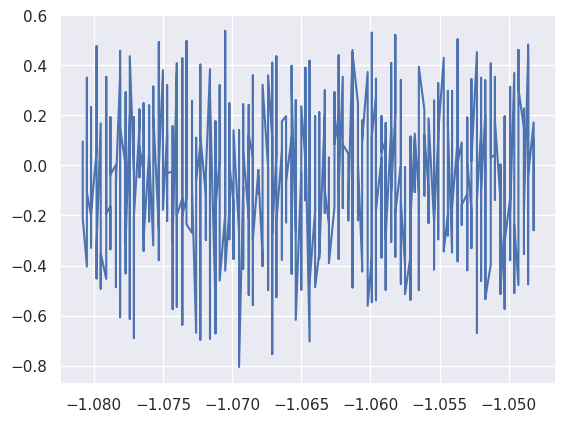

In [20]:
index = dataset["u"].sort_values(ascending=True).index.values
plt.plot(dataset["u"].values[index][10_000 : 11_000], dataset["y"].values[index][10_000 : 11_000])

In [7]:
# create time array using sampling frequency from the file
t = np.arange(len(dataset)) / 51_2000

In [ ]:
_ = plt.figure(figsize=[10, 6])

_ = plt.plot(t[:train_size], dataset["y"].iloc[:train_size])
_ = plt.plot(t[train_size:], dataset["y"].iloc[train_size:])

_ = plt.legend(["Train Outputs", "Test Outputs"])
_ = plt.savefig(fr"{plot_path}/system-outputs.png")

In [ ]:
_ = plt.figure(figsize=[10, 6])

_ = plt.plot(t[:train_size], dataset["u"].iloc[:train_size])
_ = plt.plot(t[train_size:], dataset["u"].iloc[train_size:])

_ = plt.legend(["Train Inputs", "Test Inputs"])
_ = plt.savefig(fr"{plot_path}/system-inputs.png")

In [ ]:
# Data Module

In [ ]:
dm = SimulationDataModule.from_csv(
    dataset_path=dataset_path,
    input_columns=["u"],
    output_columns=["y"],
    test_size=88_000,
    batch_size=32,
    validation_size=0.1,
    shift=1,
    forward_input_window_size=256,  # delay-line length
    forward_output_window_size=256,
    forward_output_mask=255,
)

In [ ]:
dm.setup("fit")
dm.setup("predict")

In [ ]:
for x, y in dm.train_dataloader():
    print(x.shape, y.shape)
    break

In [ ]:
for x, y in dm.test_dataloader():
    print(x.shape, y.shape)
    break

# Model

Create the model from neural network we have trained before.

The settings for kernel regression are selected using hyper-parameter search, which are the best we found for this problem.

In [ ]:
network = torch.load(model_path)
network

In [ ]:
model = BoundedSimulationTrainingModule(
    network=network,
    optimizer=None,
    lr_scheduler=None,
    bound_during_training=False,
    bound_crossing_penalty=0.0,
    bandwidth=16.0,
    kernel=kernels.triweight_kernel,
    memory_manager=NNDescentMemoryManager(epsilon=0.1),  # for 256 dimensions using nearest neighbours is required
    lipschitz_constant=1,
    delta=0.1,
    noise_variance=0.1,
    k=10,
    p=2,
    memory_device="cpu",
    predict_device="cpu",
)

In [ ]:
# preparing the memory manager and unbatching can take a while
# dataset is relatively large andigh dimensional
x, y = unbatch(dm.train_dataloader())
x.shape, y.shape

In [ ]:
model.prepare(x, y)

# Predict

Run the model is full 256 dimensions using nn-descent algorithm.

In [ ]:
outputs = model.predict_datamodule(dm, with_targets=True)

In [ ]:
_ = plt.figure(figsize=[10, 6])

plot_time = t[train_size : train_size + len(outputs["targets"])]
_ = plt.plot(plot_time, outputs["targets"].numpy().flatten())
_ = plt.plot(plot_time, outputs["nonparametric_predictions"].numpy().flatten(), c="g")
_ = plt.plot(plot_time, outputs["network_predictions"].numpy().flatten(), c="r")
# for this model bounds are really wide, since h=16, so they are well-outside plotted range
_ = plt.fill_between(plot_time, outputs["lower_bound"].numpy().flatten(), outputs["upper_bound"].numpy().flatten(), color="b", alpha=0.4)

_ = plt.ylim([-1, 1])
_ = plt.legend(["Test Data", "Kernel Regression Predictions", "Network Predictions"])
_ = plt.savefig(fr"{plot_path}/predictions-256.png")

Zoom in to see how the models behave with more detail

In [ ]:
_ = plt.figure(figsize=[10, 6])

plot_time = t[train_size : train_size + len(outputs["targets"])][10_000 : 15_000]  # zoom in on 5000 samples 
_ = plt.plot(plot_time, outputs["targets"].numpy().flatten()[10_000 : 15_000], c="g")
_ = plt.plot(plot_time, outputs["nonparametric_predictions"].numpy().flatten()[10_000 : 15_000], c="g")
_ = plt.plot(plot_time, outputs["network_predictions"].numpy().flatten()[10_000 : 15_000], c="r")
_ = plt.fill_between(plot_time, outputs["lower_bound"].numpy().flatten()[10_000 : 15_000], outputs["upper_bound"].numpy().flatten()[10_000 : 15_000], color="b", alpha=0.4)

_ = plt.ylim([-1, 1])
_ = plt.legend(["Test Data", "Kernel Regression Predictions", "Network Predictions"])
_ = plt.savefig(fr"{plot_path}/predictions-zoom-256.png")

# Evaluate

In [ ]:
def range_ratio_error(error, y_true):
    return error / (y_true.max() - y_true.min())

def report(outputs, targets):
    rmse_network = metrics.mean_squared_error(y_true=targets, y_pred=outputs["network_predictions"].numpy().flatten(), squared=False)
    rmse_nonparametric = metrics.mean_squared_error(y_true=targets, y_pred=outputs["nonparametric_predictions"].numpy().flatten(), squared=False)
    rmse_bound = metrics.mean_squared_error(y_true=targets, y_pred=outputs["lower_bound"].numpy().flatten(), squared=False)

    print(f"RMSE NET:    {rmse_network:.4f}")
    print(f"RMSE KRE:    {rmse_nonparametric:.4f}")
    print(f"RMSE BOUNDS: {rmse_bound:.4f}", end="\n\n")
    print(f"RRR NET:     {range_ratio_error(error=rmse_network, y_true=targets):.2%}")
    print(f"RRR KRE:     {range_ratio_error(error=rmse_nonparametric, y_true=targets):.2%}")
    print(f"RRR BOUNDS:  {range_ratio_error(error=rmse_bound, y_true=targets):.2%}")

In [ ]:
report(outputs, outputs["targets"].numpy().flatten())

# Different Delay-Line Length

Use the same approach, but set delay-line length to 16 for kernel-regression and 256 for neural network.
After training the network length requirement cannot be easily changed (there are some methods, but they are out of scope for this work).

In [ ]:
# define memory transformation to truncate delay-line from 256 used by network to 16 used by kernel regression
manager = NNDescentMemoryManager(epsilon=0.1, transform=TruncateDelayLine(16))

We approximated the constant using diode characteristics, but it is so large, that it bounds are extreamly wide. This benchmark shows two core problems, from which our method suffers:
1. Curse of dimensionality
2. Fast-changing nonlinearities, like exponentials

The curse of dimensionality causes the bandwidth to be large, therefore we are not able to comput meaningful bounds, due to too high `h` (note, that deterministic part of the bounds is `Lh`).
Fast-changing systems also cause the same effect, since too high $L$, makes the bounds really wide.

Reference for the diode characteristics: [https://www.vishay.com/docs/81857/1n4148.pdf](https://www.vishay.com/docs/81857/1n4148.pdf).

In [ ]:
model = BoundedSimulationTrainingModule(
    network=network,
    optimizer=None,  # not needed for inference
    lr_scheduler=None,
    bound_during_training=False,
    bound_crossing_penalty=0.0,
    bandwidth=4.0,  # using truncated delay-line allows to decrease the bandwidth by 4 times
    kernel=kernels.triweight_kernel,
    memory_manager=manager,
    lipschitz_constant=25,
    delta=0.1,
    noise_variance="estimate",
    k=32,  # increase the number of neighbour to get more accuracy
    p=2,
    memory_device="cpu",
    predict_device="cpu",
)

In [ ]:
x, y = unbatch(dm.train_dataloader())
x.shape, y.shape

In [ ]:
model.prepare(x, y)

### Predict

In [ ]:
outputs = model.predict_datamodule(dm, with_targets=True)

In [ ]:
_ = plt.figure(figsize=[10, 6])

plot_time = t[train_size : train_size + len(outputs["targets"])]
_ = plt.plot(plot_time, outputs["targets"].numpy().flatten())
_ = plt.plot(plot_time, outputs["nonparametric_predictions"].numpy().flatten(), c="g")
_ = plt.plot(plot_time, outputs["network_predictions"].numpy().flatten(), c="r")
# for this model bounds are really wide, since h=16, so they are well-outside plotted range
_ = plt.fill_between(plot_time, outputs["lower_bound"].numpy().flatten(), outputs["upper_bound"].numpy().flatten(), color="b", alpha=0.4)

_ = plt.ylim([-1, 1])
_ = plt.legend(["Test Data", "Kernel Regression Predictions", "Network Predictions"])
_ = plt.savefig(fr"{plot_path}/predictions-16.png")

In [ ]:
_ = plt.figure(figsize=[10, 6])

plot_time = t[train_size : train_size + len(outputs["targets"])][10_000 : 15_000]  # zoom in on 5000 samples 
_ = plt.plot(plot_time, outputs["targets"].numpy().flatten()[10_000 : 15_000])
_ = plt.plot(plot_time, outputs["nonparametric_predictions"].numpy().flatten()[10_000 : 15_000], c="g")
_ = plt.plot(plot_time, outputs["network_predictions"].numpy().flatten()[10_000 : 15_000], c="r")
_ = plt.fill_between(plot_time, outputs["lower_bound"].numpy().flatten()[10_000 : 15_000], outputs["upper_bound"].numpy().flatten()[10_000 : 15_000], color="b", alpha=0.4)

_ = plt.ylim([-1, 1])
_ = plt.legend(["Test Data", "Kernel Regression Predictions", "Network Predictions"])
_ = plt.savefig(fr"{plot_path}/predictions-zoom-16.png")

In [ ]:
report(outputs, outputs["targets"].numpy().flatten())